In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Session-based recommendation with Transformers4Rec
## 1. Introduction

In the previous notebook we went through our ETL pipeline with NVTabular library, and created sequential features to be used for training a session-based recommendation model. In this notebook we will learn:

- Accelerating data loading of parquet files multiple features on PyTorch using NVTabular library
- Training and evaluating an RNN-based (GRU) session-based recommendation model 
- Training and evaluating a Transformer architecture (XLNET) for session-based recommendation model
- Integrate side information (additional features) into transformer architectures in order to improve recommendation accuracy

## 2. Session-based Recommendation

Session-based recommendation, a sub-area of sequential recommendation, has been an important task in online services like e-commerce and news portals, where most users either browse anonymously or may have very distinct interests for different sessions. Session-Based Recommender Systems (SBRS) have
been proposed to model the sequence of interactions within the current user session, where a session is a short sequence of user interactions typically bounded by user inactivity. They have recently gained popularity due to their ability to capture short-term and contextual user preferences towards items.


Many methods have been proposed to leverage the sequence of interactions that occur during a session, including session-based k-NN algorithms like V-SkNN [1] and neural approaches like GRU4Rec [2]. In addition,  state of the art NLP approaches have inspired RecSys practitioners and researchers to leverage the self-attention mechanism and the Transformer-based architectures for sequential [3] and session-based recommendation [4].

## 3. Transformers4Rec Library

In this tutorial, we introduce the [Transformers4Rec](https://github.com/NVIDIA-Merlin/Transformers4Rec) open-source library for sequential and session-based recommendation task.

With Transformers4Rec we import from the HF Transformers NLP library the transformer architectures and their configuration classes. 

In addition, Transformers4Rec provides additional blocks necessary for recommendation, e.g., input features normalization and aggregation, and heads for recommendation and sequence classification/prediction. We also extend their Trainer class to allow for the evaluation with RecSys metrics.

Here are some of the most important modules:

- [TabularSequenceFeatures](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.TabularSequenceFeatures) is the input block for sequential features. Based on a `Schema` and options set by the user, it dynamically creates all the necessary layers (e.g. embedding layers) to encode, normalize, and aggregate categorical and continuous features. It also allows to set the `masking` training approach (e.g. Causal LM, Masked LM).
- [TransformerBlock](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.TransformerBlock) class is the bridge that adapts HuggingFace Transformers for session-based and sequential-based recommendation models.
- [SequentialBlock](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.SequentialBlock) allows the definition of a model body as as sequence of layer (similarly to [torch.nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). It is designed to define our model as a sequence of layers and automatically setting the input shape of a layer from the output shape of the previous one.
- [Head](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.Head) class defines the head of a model.
- [NextItemPredictionTask](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.NextItemPredictionTask) is the class to support next item prediction task, combining a model body with a head.
- [Trainer](https://nvidia-merlin.github.io/Transformers4Rec/main/api/transformers4rec.torch.html#transformers4rec.torch.Trainer) extends the `Trainer` class from HF transformers and manages the model training and evaluation.

You can check the [full documentation](https://nvidia-merlin.github.io/Transformers4Rec/main/index.html) of Transformers4Rec if needed.

In Figure 1, we present a reference architecture that we are going to build with Transformers4Rec PyTorch API in this notebook. We are going to start using only `product-id` as input feature, but as you can notice in the figure, we can add additional categorical and numerical features later to improve recommendation accuracy, as shown in Section 3.2.4.

![](_images/tf4rec_meta.png)  
<p><center>Figure 1. Transformers4Rec meta-architecture.</center></p>

### 3.1 Training an RNN-based Session-based Recommendation Model

In this section, we use a type of Recurrent Neural Networks (RNN) - the Gated Recurrent Unit (GRU)[5] - to do next-item prediction using a sequence of events (e.g., click, view, or purchase) per user in a given session. There is obviously some sequential patterns that we want to capture to provide more relevant recommendations. In our case, the input of the GRU layer is a representation of the user interaction, the internal GRU hidden state encodes a representation of the session based on past interactions and the outputs are the next-item predictions. Basically, for each item in a given session, we generate the output as the predicted preference of the items, i.e. the likelihood of being the next.

Figure 2 illustrates the logic of predicting next item in a given session. First, the product ids are embedded and fed as a sequence to a GRU layer, which outputs a representation than can be used to predict the next item. For the sake of simplicity, we treat the recommendation as a multi-class classification problem and use cross-entropy loss. In our first example, we use a GRU block instead of `Transformer block` (shown in the Figure 1).

![](_images/gru_based.png)
<p><center>Figure 2. Next item prediction with RNN.</center></p>

#### 3.1.1 Import Libraries and Modules

In [2]:
import os
import glob

import torch 
import transformers4rec.torch as tr

from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt
from transformers4rec.torch.utils.examples_utils import wipe_memory

##### Instantiates Schema object from a `schema` file.

In [3]:
from merlin_standard_lib import Schema
# Define schema object to pass it to the TabularSequenceFeatures class
SCHEMA_PATH = 'schema_tutorial.pb'
schema = Schema().from_proto_text(SCHEMA_PATH)
schema = schema.select_by_name(['product_id-list_seq'])

Transformers4Rec library relies on `Schema` object in `TabularSequenceFeatures` that takes the input features as input and create all the necessary layers to process and aggregate them. As you can see below, the `schema.pb` is a protobuf text file contains features metadata, including statistics about features such as cardinality, min and max values and also tags based on their characteristics and dtypes (e.g., `categorical`, `continuous`, `list`, `item_id`). We can tag our target column and even add the prediction task such as `binary`, `regression` or `multiclass` as tags for the target column in the `schema.pb` file. The `Schema` provides a standard representation for metadata that is useful when training machine learning or deep learning models.

The metadata information loaded from `Schema` and their tags are used to automatically set the parameters of Transformers4rec models. Certain Transformers4rec modules have a `from_schema()` method to instantiate their parameters and layers from protobuf text file respectively. 

Although in this tutorial we are defining the `Schema` manually, the next NVTabular release is going to generate the schema with appropriate types and tags automatically from the preprocessing workflow, allowing the user to set additional feaure tags if needed.

Let's inspect the first lines of `schema.pb`

In [4]:
!head -30 $SCHEMA_PATH

feature {
  name: "user_session"
  type: INT
  int_domain {
    name: "user_session"
    min: 1
    max: 1877365
    is_categorical: false
  }
  annotation {
    tag: "groupby_col"
  }
}
feature {
  name: "category_id-list_seq"
  value_count {
    min: 2
    max: 20
  }
  type: INT
  int_domain {
    name: "category_id-list_seq"
    min: 1
    max: 566
    is_categorical: true
  }
  annotation {
    tag: "list"
    tag: "categorical"
    tag: "item"


##### Defining the input block: `TabularSequenceFeatures`

We define our input block using `TabularSequenceFeatures` class. The `from_schema()` method directly parses the schema and accepts sequential and non-sequential features. Based on the `Schema` and some user-defined options, the categorical features are represented by embeddings and numerical features can be represented as continuous scalars or by a technique named Soft One-Hot embeddings (more info in our [paper's online appendix](https://github.com/NVIDIA-Merlin/publications/blob/main/2021_acm_recsys_transformers4rec/Appendices/Appendix_A-Techniques_used_in_Transformers4Rec_Meta-Architecture.md)). 

The embedding features can optionally be normalized (`layer_norm=True`). Data augmentation methods like "Stochastic Swap Noise" (`pre="stochastic-swap-noise"`) and `aggregation` opptions (like `concat` and `elementwise-sum`) are also available. The continuous features can also be combined and projected by MLP layers by setting `continuous_projection=[dim]`. Finally, the `max_sequence_length` argument defines the maximum sequence length of our sequential input.

Another important argument is the `masking` method, which sets the training approach. See Section 3.2.2 for details on this.

In [5]:
sequence_length = 20
inputs = tr.TabularSequenceFeatures.from_schema(
        schema,
        max_sequence_length= sequence_length,
        masking = 'causal',
    )

##### Connecting the blocks with `SequentialBlock`

The `SequentialBlock` creates a pipeline by connecting the building blocks in a serial way, so that the input shape of one block is inferred from the output of the previous block. In this example, the `TabularSequenceFeatures` object is followed by an MLP projection layer, which feeds data to a GRU block.

In [6]:
d_model = 128
body = tr.SequentialBlock(
        inputs,
        tr.MLPBlock([d_model]),
        tr.Block(torch.nn.GRU(input_size=d_model, hidden_size=d_model, num_layers=1), [None, 20, d_model])
)

##### Item Prediction head and tying embeddings

In our experiments published in our [ACM RecSys'21 paper](https://github.com/NVIDIA-Merlin/publications/blob/main/2021_acm_recsys_transformers4rec/recsys21_transformers4rec_paper.pdf) [8], we used the next item prediction head, which projects the output of the RNN/Transformer block to the items space, followed by a softmax layer to produce the relevance scores over all items. For the output layer we provide the `Tying Embeddings` technique (`weight_tying`). It was proposed originally by the NLP community to tie the weights of the input (item id) embedding matrix with the output projection layer, showed to be a very effective technique in extensive experimentation for competitions and empirical analysis (for more details see our [paper](https://github.com/NVIDIA-Merlin/publications/blob/main/2021_acm_recsys_transformers4rec/recsys21_transformers4rec_paper.pdf) and its online [appendix](https://github.com/NVIDIA-Merlin/publications/blob/main/2021_acm_recsys_transformers4rec/Appendices/Appendix_A-Techniques_used_in_Transformers4Rec_Meta-Architecture.md)). In practice, such technique helps the network to learn faster item embeddings even for rare items, reduces the number of parameters for large item cardinalities and enables Approximate Nearest Neighbours (ANN) search on inference, as the predictions can be obtained by a dot product between the model output and the item embeddings.

Next, we link the transformer-body to the inputs and the prediction tasks to get the final PyTorch `Model` class.

In [7]:
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True, hf_format=True, 
                              metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),  
                                       RecallAt(top_ks=[10, 20], labels_onehot=True)]),
)
model = tr.Model(head)

Projecting inputs of NextItemPredictionTask to'64' As weight tying requires the input dimension '128' to be equal to the item-id embedding dimension '64'


##### Define a Dataloader function from schema

We use optimized NVTabular PyTorch Dataloader which has the following benefits:
- removing bottlenecks from dataloading by processing large chunks of data at a time instead iterating by row
- processing datasets that don’t fit within the GPU or CPU memory by streaming from the disk
- reading data directly into the GPU memory and removing CPU-GPU communication
- preparing batch asynchronously into the GPU to avoid CPU-GPU communication
- supporting commonly used formats such as parquet
- having native support to sparse sequential features

In [8]:
# import NVTabular dependencies
from transformers4rec.torch.utils.data_utils import NVTabularDataLoader

x_cat_names, x_cont_names = ['product_id-list_seq'], []

# dictionary representing max sequence length for column
sparse_features_max = {
    fname: sequence_length
    for fname in x_cat_names + x_cont_names
}

# Define a `get_dataloader` function to call in the training loop
def get_dataloader(path, batch_size=32):

    return NVTabularDataLoader.from_schema(
        schema,
        path, 
        batch_size,
        max_sequence_length=sequence_length,
        sparse_names=x_cat_names + x_cont_names,
        sparse_max=sparse_features_max,
)

##### Daily Fine-Tuning: Training over a time window

Now that the model is defined, we are going to launch training. For that, Transfromers4rec extends the HF Transformers `Trainer` class to adapt the evaluation loop for session-based recommendation task and the calculation of ranking metrics. 
The original HF `Trainer.train()` method is not overloaded, meaning that we leverage the efficient training implementation from HF transformers library, which manages for example half-precision (FP16) training.

##### Set training arguments

In [9]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

#Set arguments for training 
train_args = T4RecTrainingArguments(local_rank = -1, 
                                    dataloader_drop_last = False,
                                    report_to = [],   #set empty list to avoid logging metrics to Weights&Biases
                                    gradient_accumulation_steps = 1,
                                    per_device_train_batch_size = 256, 
                                    per_device_eval_batch_size = 32,
                                    output_dir = "./tmp", 
                                    max_sequence_length=sequence_length,
                                    learning_rate=0.00071,
                                    num_train_epochs=3,
                                    logging_steps=200,
                                   )

##### Instantiate the Trainer

In [10]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=train_args,
    schema=schema,
    compute_metrics=True,
)

Define the output folder of the processed parquet files

In [11]:
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/workspace/data/sessions_by_day")

##### Model finetuning and incremental evaluation
Training models incrementally, e.g. fine-tuning pre-trained models with new data over time is a common practice in industry to scale to the large streaming data been generated every data. Furthermore, it is common to evaluate recommendation models on data that came after the one used to train the models, for a more realistic evaluation.

Here, we use a loop that to conduct a time-based finetuning, by iteratively training and evaluating using a sliding time window as follows: At each iteration, we use training data of a specific time index <i>t</i> to train the model then we evaluate on the validation data of next index <i>t + 1</i>. We set the start time to 1 and end time to 4.

In [12]:
%%time
start_time_window_index = 1
final_time_window_index = 4
for time_index in range(start_time_window_index, final_time_window_index):
    # Set data 
    time_index_train = time_index
    time_index_eval = time_index + 1
    train_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_train}/train.parquet"))
    eval_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_eval}/valid.parquet"))
    
    # Initialize dataloaders
    trainer.train_dataloader = get_dataloader(train_paths, train_args.per_device_train_batch_size)
    trainer.eval_dataloader = get_dataloader(eval_paths, train_args.per_device_eval_batch_size)
    
    # Train on day related to time_index 
    print('*'*20)
    print("Launch training for day %s are:" %time_index)
    print('*'*20 + '\n')
    trainer.reset_lr_scheduler()
    trainer.train()
    trainer.state.global_step +=1
    
    # Evaluate on the following day
    train_metrics = trainer.evaluate(metric_key_prefix='eval')
    print('*'*20)
    print("Eval results for day %s are:\t" %time_index_eval)
    print('\n' + '*'*20 + '\n')
    for key in sorted(train_metrics.keys()):
        print(" %s = %s" % (key, str(train_metrics[key]))) 
    wipe_memory()

***** Running training *****
  Num examples = 112128
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1314


********************
Launch training for day 1 are:
********************



Step,Training Loss
200,9.998800
400,9.232800
600,8.988600
800,8.909300
1000,8.806200
1200,8.794200


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 2 are:	

********************

 eval/loss = 8.856975555419922
 eval/next-item/ndcg_at_10 = 0.03842613101005554
 eval/next-item/ndcg_at_20 = 0.04755885899066925
 eval/next-item/recall_at_10 = 0.07503204792737961
 eval/next-item/recall_at_20 = 0.11130382120609283
 eval_runtime = 7.7593
 eval_samples_per_second = 1711.5
 eval_steps_per_second = 53.484


***** Running training *****
  Num examples = 106240
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1245


********************
Launch training for day 2 are:
********************



Step,Training Loss
200,8.966600
400,8.843700
600,8.653300
800,8.556200
1000,8.428500
1200,8.404300


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 3 are:	

********************

 eval/loss = 8.518232345581055
 eval/next-item/ndcg_at_10 = 0.05569075420498848
 eval/next-item/ndcg_at_20 = 0.06843017041683197
 eval/next-item/recall_at_10 = 0.10552927851676941
 eval/next-item/recall_at_20 = 0.15609200298786163
 eval_runtime = 7.3871
 eval_samples_per_second = 1663.442
 eval_steps_per_second = 51.983


***** Running training *****
  Num examples = 97792
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1146


********************
Launch training for day 3 are:
********************



Step,Training Loss
200,8.601800
400,8.478500
600,8.281100
800,8.190300
1000,8.048100


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 4 are:	

********************

 eval/loss = 8.1531982421875
 eval/next-item/ndcg_at_10 = 0.06854147464036942
 eval/next-item/ndcg_at_20 = 0.08415079861879349
 eval/next-item/recall_at_10 = 0.1280597746372223
 eval/next-item/recall_at_20 = 0.1900927573442459
 eval_runtime = 9.4121
 eval_samples_per_second = 1652.345
 eval_steps_per_second = 51.636
CPU times: user 2min 43s, sys: 5.41 s, total: 2min 48s
Wall time: 3min 22s


Let's write out model evaluation accuracy results to a text file to compare model at the end

In [13]:
with open("results.txt", 'w') as f: 
    f.write('GRU accuracy results:')
    f.write('\n')
    for key, value in  model.compute_metrics().items(): 
        f.write('%s:%s\n' % (key, value.item()))

#### Metrics

We have extended the HuggingFace transformers Trainer class (PyTorch only) to support evaluation of RecSys metrics. The following information
retrieval metrics are used to compute the Top-20 accuracy of recommendation lists containing all items: <br> 
- **Normalized Discounted Cumulative Gain (NDCG@20):** NDCG accounts for rank of the relevant item in the recommendation list and is a more fine-grained metric than HR, which only verifies whether the relevant item is among the top-k items.

- **Hit Rate (HR@20)**: Also known as `Recall@n` when there is only one relevant item in the recommendation list. HR just verifies whether the relevant item is among the top-n items.

##### Restart the kernel to free our GPU memory

In [14]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

At this stage if the kernel does not restart automatically, we expect you to manually restart the kernel to free GPU memory so that you can move on to the next session-based model training with a SOTA deep learning Transformer-based model, [XLNet](https://arxiv.org/pdf/1906.08237.pdf).

### 3.2. Training a Transformer-based Session-based Recommendation Model

#### 3.2.1 What's Transformers?

The Transformer is a competitive alternative to the models using Recurrent Neural Networks (RNNs) for a range of sequence modeling tasks. The Transformer architecture [6] was introduced as a novel architecture in NLP domain that aims to solve sequence-to-sequence tasks relying entirely on self-attention mechanism to compute representations of its input and output. Hence, the Transformer overperforms RNNs with their three mechanisms: 

- Non-sequential: Transformers network is parallelized where as RNN computations are inherently sequential. That resulted in significant speed-up in the training time.
- Self-attention mechanisms: Transformers rely entirely on self-attention mechanisms that directly model relationships between all item-ids in a sequence.  
- Positional encodings: A representation of the location or “position” of items in a sequence which is used to give the order context to the model architecture.

![](_images/transformer_vs_rnn.png)
<p><center> Figure 3. Transformer vs vanilla RNN.</center></p>

Figure 4 illustrates the differences of Transformer (self-attention based) and a vanilla RNN architecture. As we see, RNN cannot be parallelized because it uses sequential processing over time (notice the sequential path from previous cells to the current one). On the other hand, the Transformer is a more powerful architecture because the self-attention mechanism is capable of representing dependencies within the sequence of tokens, favors parallel processing and handle longer sequences.

As illustrated in the [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper, the original transformer model is made up of an encoder and decoder where each is a stack we can call a transformer block. In Transformers4Rec architectures we use the encoder block of transformer architecture.

![](_images/encoder.png)
<p><center> Figure 4. Encoder block of the Transformer Architecture.</center></p>

#### 3.2.2. XLNet

Here, we use XLNet [10] as the Transformer block in our architecture. It was originally proposed to be trained with the *Permutation Language Modeling (PLM)*  technique, that combines the advantages of autoregressive (Causal LM) and autoencoding (Masked LM). Although, we found out in our [paper](https://github.com/NVIDIA-Merlin/publications/blob/main/2021_acm_recsys_transformers4rec/recsys21_transformers4rec_paper.pdf) [8] that the *Masked Language Model (MLM)* approach worked better than PLM for the small sequences in session-based recommendation, thus we use MLM for this example. MLM was introduced in *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding* paper [8]. 

Figure 5 illustrates the causal language modeling (LM) and masked LM. In this example, we use in causal LM for RNN masked LM for XLNet. Causal LM is the task of predicting the token following a sequence of tokens, where the model only attends to the left context, i.e. models the probability of a token given the previous tokens in a sentence [7]. On the other hand, the MLM randomly masks some of the tokens from the input sequence, and the objective is to predict the original vocabulary id of the masked word based only on its bi-directional context. When we train with MLM, the Transformer layer is also allowed to use positions on the right (future information) during training. During inference, all past items are visible for the Transformer layer, which tries to predict the next item. It performs a type of data augmentation, by masking different positions of the sequences in each training epoch.

![](_images/masking.png)
<p><center>Figure 5. Causal and Masked Language Model masking methods.</center></p>

####  3.2.3 Train XLNET for Next Item Prediction

Now we are going to define an architecture for next-item prediction using the XLNET architecture.

In [15]:
import os
import glob

import torch 
import transformers4rec.torch as tr

from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt

As we did above, we start with defining our schema object and selecting only the `product_id` feature for training.

In [16]:
from merlin_standard_lib import Schema

# Define schema object to pass it to the TabularSequenceFeatures class
SCHEMA_PATH = 'schema_tutorial.pb'
schema = Schema().from_proto_text(SCHEMA_PATH)

# Create a sub-schema only with the selected features
schema = schema.select_by_name(['product_id-list_seq'])

##### Define Input block
Here we instantiate `TabularSequenceFeatures` from the feature schema and set `masking="mlm"` to use MLM as training method.

In [17]:
#Input 
sequence_length, d_model = 20, 192
# Define input module to process tabular input-features and to prepare masked inputs
inputs= tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=sequence_length,
    d_output=d_model,
    masking="mlm",
)

We have inherited the original `XLNetConfig` class of HF transformers with some default arguments in the `build()` method. Here we use it to instantiate an XLNET model according to the arguments (`d_model`, `n_head`, etc.), defining the model architecture.

The `TransformerBlock` class supports HF Transformers for session-based and sequential-based recommendation models. `NextItemPredictionTask` is the class to support next item prediction task, encapsulating the corresponding heads and loss.

In [18]:
# Define XLNetConfig class and set default parameters for HF XLNet config  
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=4, n_layer=2, total_seq_length=sequence_length
)
# Define the model block including: inputs, masking, projection and transformer block.
body = tr.SequentialBlock(
    inputs, tr.MLPBlock([192]), tr.TransformerBlock(transformer_config, masking=inputs.masking)
)

# Define the head for to next item prediction task 
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True, hf_format=True, 
                              metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),  
                                       RecallAt(top_ks=[10, 20], labels_onehot=True)]),
)

# Get the end-to-end Model class 
model = tr.Model(head)

Projecting inputs of NextItemPredictionTask to'64' As weight tying requires the input dimension '192' to be equal to the item-id embedding dimension '64'


**Set training arguments**

Among the training arguments you can set the `data_loader_engine` to automatically instantiate the dataloader based on the schema, rather than instantiating the data loader manually like we did for the RNN example. The default value is `"nvtabular"` for optimized GPU-based data-loading. Optionally the PyarrowDataLoader (`"pyarrow"`) can also be used as a basic option, but it is slower and works only for small datasets, as the full data is loaded into CPU memory.

In [19]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

#Set arguments for training 
training_args = T4RecTrainingArguments(
            output_dir="./tmp",
            max_sequence_length=20,
            data_loader_engine='nvtabular',
            num_train_epochs=3, 
            dataloader_drop_last=False,
            per_device_train_batch_size = 256,
            per_device_eval_batch_size = 32,
            gradient_accumulation_steps = 1,
            learning_rate=0.000666,
            report_to = [],
            logging_steps=200,
        )

PyTorch: setting up devices


**Instantiate the trainer**

In [20]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    schema=schema,
    compute_metrics=True,
)

Define the output folder of the processed parquet files

In [21]:
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/workspace/data/sessions_by_day")

Now, we do time-based fine-tuning the model by iteratively training and evaluating using a sliding time window, like we did for the RNN example.

In [22]:
%%time
start_time_window_index = 1
final_time_window_index = 4
for time_index in range(start_time_window_index, final_time_window_index):
    # Set data 
    time_index_train = time_index
    time_index_eval = time_index + 1
    train_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_train}/train.parquet"))
    eval_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_eval}/valid.parquet"))
    # Train on day related to time_index 
    print('*'*20)
    print("Launch training for day %s are:" %time_index)
    print('*'*20 + '\n')
    trainer.train_dataset_or_path = train_paths
    trainer.reset_lr_scheduler()
    trainer.train()
    trainer.state.global_step +=1
    # Evaluate on the following day
    trainer.eval_dataset_or_path = eval_paths
    train_metrics = trainer.evaluate(metric_key_prefix='eval')
    print('*'*20)
    print("Eval results for day %s are:\t" %time_index_eval)
    print('\n' + '*'*20 + '\n')
    for key in sorted(train_metrics.keys()):
        print(" %s = %s" % (key, str(train_metrics[key]))) 
    wipe_memory()

***** Running training *****
  Num examples = 112128
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1314


********************
Launch training for day 1 are:
********************



Step,Training Loss
200,9.927000
400,9.046400
600,8.779300
800,8.635800
1000,8.539400
1200,8.507000


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 2 are:	

********************

 epoch = 3.0
 eval/loss = 8.753535270690918
 eval/next-item/ndcg_at_10 = 0.049175068736076355
 eval/next-item/ndcg_at_20 = 0.06000332161784172
 eval/next-item/recall_at_10 = 0.09177286922931671
 eval/next-item/recall_at_20 = 0.1346806436777115
 eval_runtime = 7.0703
 eval_samples_per_second = 1878.271
 eval_steps_per_second = 58.696
********************
Launch training for day 2 are:
********************



***** Running training *****
  Num examples = 106240
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1245


Step,Training Loss
200,8.635100
400,8.523100
600,8.375600
800,8.322400
1000,8.232100
1200,8.209900


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 3 are:	

********************

 epoch = 3.0
 eval/loss = 8.421579360961914
 eval/next-item/ndcg_at_10 = 0.061416078358888626
 eval/next-item/ndcg_at_20 = 0.07491344213485718
 eval/next-item/recall_at_10 = 0.11719132959842682
 eval/next-item/recall_at_20 = 0.17060838639736176
 eval_runtime = 7.0074
 eval_samples_per_second = 1753.564
 eval_steps_per_second = 54.799
********************
Launch training for day 3 are:
********************



***** Running training *****
  Num examples = 97792
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1146


Step,Training Loss
200,8.312100
400,8.226900
600,8.095400
800,8.065600
1000,7.965600


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 4 are:	

********************

 epoch = 3.0
 eval/loss = 8.107558250427246
 eval/next-item/ndcg_at_10 = 0.07384572923183441
 eval/next-item/ndcg_at_20 = 0.08944202959537506
 eval/next-item/recall_at_10 = 0.13939706981182098
 eval/next-item/recall_at_20 = 0.20175212621688843
 eval_runtime = 8.9372
 eval_samples_per_second = 1740.144
 eval_steps_per_second = 54.38
CPU times: user 6min 57s, sys: 14.3 s, total: 7min 11s
Wall time: 2min 35s


Add eval accuracy metric results to the existing resuls.txt file.

In [23]:
with open("results.txt", 'a') as f:
    f.write('\n')
    f.write('XLNet-MLM accuracy results:')
    f.write('\n')
    for key, value in  model.compute_metrics().items(): 
        f.write('%s:%s\n' % (key, value.item()))

#### Restart the kernel to free our GPU memory

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

At this stage if the kernel does not restart automatically, we expect you to manually restart the kernel to free GPU memory so that you can move on to the next session-based model training with XLNet using side information.

#### 3.2.4 Train XLNET with Side Information for Next Item Prediction

It is a common practice in RecSys to leverage additional tabular features of item (product) metadata and user context, providing the model more
information for meaningful predictions. With that motivation, in this section, we will use additional features to train our XLNET architecture. We already checked our `schema.pb`, saw that it includes features and their tags. Now it is time to use these additional features that we created in the `02_ETL-with-NVTabular.ipynb` notebook.

In [1]:
import os
import glob
import nvtabular as nvt

import torch 
import transformers4rec.torch as tr

from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt

In [2]:
# Define categorical and continuous columns to fed to training model
x_cat_names = ['product_id-list_seq', 'category_id-list_seq', 'brand-list_seq']
x_cont_names = ['product_recency_days_log_norm-list_seq', 'et_dayofweek_sin-list_seq', 'et_dayofweek_cos-list_seq', 
                'price_log_norm-list_seq', 'relative_price_to_avg_categ_id-list_seq']

from merlin_standard_lib import Schema

# Define schema object to pass it to the TabularSequenceFeatures class
SCHEMA_PATH ='schema_tutorial.pb'
schema = Schema().from_proto_text(SCHEMA_PATH)
schema = schema.select_by_name(x_cat_names + x_cont_names)

Here we set `aggregation="concat"`, so that all categorical and continuous features are concatenated to form an interaction representation.

In [3]:
# Define input block
sequence_length, d_model = 20, 192
# Define input module to process tabular input-features and to prepare masked inputs
inputs= tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=sequence_length,
    aggregation="concat",
    d_output=d_model,
    masking="mlm",
)

# Define XLNetConfig class and set default parameters for HF XLNet config  
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=4, n_layer=2, total_seq_length=sequence_length
)
# Define the model block including: inputs, masking, projection and transformer block.
body = tr.SequentialBlock(
    inputs, tr.MLPBlock([192]), tr.TransformerBlock(transformer_config, masking=inputs.masking)
)

# Define the head related to next item prediction task 
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True, hf_format=True, 
                                     metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),  
                                              RecallAt(top_ks=[10, 20], labels_onehot=True)]),
)

# Get the end-to-end Model class 
model = tr.Model(head)

Projecting inputs of NextItemPredictionTask to'64' As weight tying requires the input dimension '192' to be equal to the item-id embedding dimension '64'


##### Training and Evaluation

In [4]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer
from transformers4rec.torch.utils.examples_utils import wipe_memory

#Set arguments for training 
training_args = T4RecTrainingArguments(
            output_dir="./tmp",
            max_sequence_length=20,
            data_loader_engine='nvtabular',
            num_train_epochs=3, 
            dataloader_drop_last=False,
            per_device_train_batch_size = 256,
            per_device_eval_batch_size = 32,
            gradient_accumulation_steps = 1,
            learning_rate=0.000666,
            report_to = [],
            logging_steps=200,
)

In [5]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    schema=schema,
    compute_metrics=True,
)

Define the output folder of the processed parquet files

In [6]:
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/workspace/data/sessions_by_day")

In [7]:
%%time
start_time_window_index = 1
final_time_window_index = 4
for time_index in range(start_time_window_index, final_time_window_index):
    # Set data 
    time_index_train = time_index
    time_index_eval = time_index + 1
    train_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_train}/train.parquet"))
    eval_paths = glob.glob(os.path.join(OUTPUT_DIR, f"{time_index_eval}/valid.parquet"))
    # Train on day related to time_index 
    print('*'*20)
    print("Launch training for day %s are:" %time_index)
    print('*'*20 + '\n')
    trainer.train_dataset_or_path = train_paths
    trainer.reset_lr_scheduler()
    trainer.train()
    trainer.state.global_step +=1
    # Evaluate on the following day
    trainer.eval_dataset_or_path = eval_paths
    train_metrics = trainer.evaluate(metric_key_prefix='eval')
    print('*'*20)
    print("Eval results for day %s are:\t" %time_index_eval)
    print('\n' + '*'*20 + '\n')
    for key in sorted(train_metrics.keys()):
        print(" %s = %s" % (key, str(train_metrics[key]))) 
    wipe_memory()

********************
Launch training for day 1 are:
********************



***** Running training *****
  Num examples = 112128
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1314


Step,Training Loss
200,9.836900
400,8.937700
600,8.665200
800,8.518700
1000,8.411900
1200,8.371200


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 2 are:	

********************

 epoch = 3.0
 eval/loss = 8.605655670166016
 eval/next-item/ndcg_at_10 = 0.0545700266957283
 eval/next-item/ndcg_at_20 = 0.06626961380243301
 eval/next-item/recall_at_10 = 0.10270718485116959
 eval/next-item/recall_at_20 = 0.14915919303894043
 eval_runtime = 9.5026
 eval_samples_per_second = 1397.507
 eval_steps_per_second = 43.672
********************
Launch training for day 2 are:
********************



***** Running training *****
  Num examples = 106240
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1245


Step,Training Loss
200,8.466200
400,8.315800
600,8.120000
800,8.036200
1000,7.920700
1200,7.883900


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 3 are:	

********************

 epoch = 3.0
 eval/loss = 8.162181854248047
 eval/next-item/ndcg_at_10 = 0.0733010321855545
 eval/next-item/ndcg_at_20 = 0.08980806171894073
 eval/next-item/recall_at_10 = 0.13904747366905212
 eval/next-item/recall_at_20 = 0.20428968966007233
 eval_runtime = 9.1126
 eval_samples_per_second = 1348.468
 eval_steps_per_second = 42.14
********************
Launch training for day 3 are:
********************



***** Running training *****
  Num examples = 97792
  Num Epochs = 3
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 1146


Step,Training Loss
200,8.016800
400,7.900500
600,7.740200
800,7.691500
1000,7.583600


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./tmp/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




********************
Eval results for day 4 are:	

********************

 epoch = 3.0
 eval/loss = 7.774728775024414
 eval/next-item/ndcg_at_10 = 0.09089759737253189
 eval/next-item/ndcg_at_20 = 0.10928591340780258
 eval/next-item/recall_at_10 = 0.16947951912879944
 eval/next-item/recall_at_20 = 0.24214120209217072
 eval_runtime = 11.8897
 eval_samples_per_second = 1308.02
 eval_steps_per_second = 40.876
CPU times: user 7min 29s, sys: 16.9 s, total: 7min 45s
Wall time: 3min 10s


Add XLNet-MLM with side information accuracy results to the `results.txt`

In [8]:
with open("results.txt", 'a') as f:
    f.write('\n')
    f.write('XLNet-MLM with side information accuracy results:')
    f.write('\n')
    for key, value in  model.compute_metrics().items(): 
        f.write('%s %s\n' % (key, value.item()))

After model training and evaluation is completed we can save our trained model in the next section. 

##### Exporting the preprocessing workflow and model for deployment to Triton server

Load the preproc workflow that we saved in the ETL notebook.

In [9]:
import nvtabular as nvt

# define data path about where to get our data
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", "/workspace/data/")
workflow_path = os.path.join(INPUT_DATA_DIR, 'workflow_etl')
workflow = nvt.Workflow.load(workflow_path)

In [10]:
# dictionary representing max sequence length for the sequential (list) columns
sparse_features_max = {
    fname: sequence_length
    for fname in x_cat_names + x_cont_names
}

sparse_features_max

{'product_id-list_seq': 20,
 'category_id-list_seq': 20,
 'brand-list_seq': 20,
 'product_recency_days_log_norm-list_seq': 20,
 'et_dayofweek_sin-list_seq': 20,
 'et_dayofweek_cos-list_seq': 20,
 'price_log_norm-list_seq': 20,
 'relative_price_to_avg_categ_id-list_seq': 20}

It is time to export the proc workflow and model in the format required by Triton Inference Server, by using the NVTabular’s `export_pytorch_ensemble()` function.

In [11]:
from nvtabular.inference.triton import export_pytorch_ensemble
export_pytorch_ensemble(
    model,
    workflow,
    sparse_max=sparse_features_max,
    name= "t4r_pytorch",
    model_path= "/workspace/models",
    label_columns =[],
)

Before we move on to the next notebook, `04-Inference-with-Triton`, let's print out our results.txt file. 

In [2]:
!cat results.txt

GRU accuracy results:
next-item/ndcg_at_10:0.07151895016431808
next-item/ndcg_at_20:0.08768121898174286
next-item/recall_at_10:0.1361762434244156
next-item/recall_at_20:0.20020613074302673

XLNet-MLM accuracy results:
next-item/ndcg_at_10:0.07384572923183441
next-item/ndcg_at_20:0.08944202959537506
next-item/recall_at_10:0.13939706981182098
next-item/recall_at_20:0.20175212621688843

XLNet-MLM with side information accuracy results:
next-item/ndcg_at_10:0.08558817952871323
next-item/ndcg_at_20:0.10371016710996628
next-item/recall_at_10:0.1605256348848343
next-item/recall_at_20:0.2324143350124359

Let's plot bar charts to visualize and compare the accuracy results using `visuals` util function.

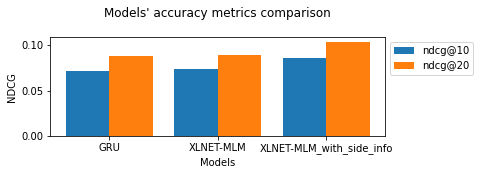

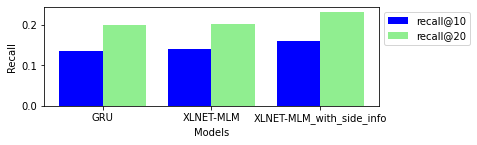

In [1]:
from visuals import create_bar_chart
create_bar_chart('results.txt')

**In the end, using side information provided higher accuracy. Why is that? Have an idea?**

## Wrap Up

Congratulations on finishing this notebook. In this tutorial, we have presented Transformers4Rec, an open source library designed to enable RecSys researchers and practitioners to quickly and easily explore the latest developments of the NLP for sequential and session-based recommendation tasks.

Please execute the cell below to shut down the kernel before moving on to the next notebook, `04-Inference-with-Triton.ipynb`.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## References

[1] Malte Ludewig and Dietmar Jannach. 2018. Evaluation of session-based recommendation algorithms. User Modeling and User-Adapted Interaction 28, 4-5 (2018), 331–390.<br>
[2] Balázs Hidasi and Alexandros Karatzoglou. 2018. Recurrent neural networks with top-k gains for session-based recommendations. In Proceedings of the 27th ACMinternational conference on information and knowledge management. 843–852.<br>
[3] Fei Sun, Jun Liu, Jian Wu, Changhua Pei, Xiao Lin, Wenwu Ou, and Peng Jiang. 2019. BERT4Rec: Sequential recommendation with bidirectional encoder representations from transformer. In Proceedings of the 28th ACM international conference on information and knowledge management. 1441–1450.
[4] Shiming Sun, Yuanhe Tang, Zemei Dai, and Fu Zhou. 2019. Self-attention network for session-based recommendation with streaming data input. IEEE Access 7 (2019), 110499–110509.  
[5] Kyunghyun Cho, Bart Van Merriënboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, and Yoshua Bengio. 2014. Learning phrase representations using RNN encoder-decoder for statistical machine translation. arXiv preprint arXiv:1406.1078 (2014).  
[6] Vaswani, A., et al. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).  
[7] Lample, Guillaume, and Alexis Conneau. "Cross-lingual language model pretraining." arXiv preprint arXiv:1901.07291  
[8] Gabriel De Souza P. Moreira, et al. (2021). Transformers4Rec: Bridging the Gap between NLP and Sequential / Session-Based Recommendation. RecSys'21.  
[9] Understanding XLNet, BorealisAI. Online available: https://www.borealisai.com/en/blog/understanding-xlnet/  
[10] Yang, Zhilin, et al. "Xlnet: Generalized autoregressive pretraining for language understanding." Advances in neural information processing systems 32 (2019).